<a href="https://colab.research.google.com/github/IliasMCBM/Optimizing-Tomato-Quality-Detection-with-YOLOv11-and-Intel-OpenVINO/blob/main/Yolov11_Tomato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing Tomato Quality Detection with YOLOv11 and Intel OpenVINO

# Prerequisites

In [15]:
%pip install -q "openvino>=2024.0.0" "nncf>=2.9.0"
%pip install -q "torch>=2.1" "torchvision>=0.16" "ultralytics==8.3.0" onnx tqdm opencv-python --extra-index-url https://download.pytorch.org/whl/cpu
%pip install roboflow

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [1]:
!git clone https://huggingface.co/IliasMCBM/Yolov11_Tomato


Cloning into 'Yolov11_Tomato'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 15 (delta 2), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (15/15), 56.91 KiB | 1.46 MiB/s, done.
Filtering content: 100% (3/3), 17.56 MiB | 15.73 MiB/s, done.


# Setting Up the Working Directory and Custom Cell Magic

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [5]:
%cd {HOME}/Yolov11_Tomato

/content/Yolov11_Tomato


In [4]:
!ls

best_int8_openvino_model  best_openvino_model  best.pt	README.md


In [11]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    pass

# Downloading Dataset and Training the YOLO Model

In [13]:
%%skip

from roboflow import Roboflow
rf = Roboflow(api_key="ROBOFLOW_API_KEY")
project = rf.workspace("tomato-mjotb").project("tomato_grading")
version = project.version(10)
dataset = version.download("yolov11")

In [ ]:
%%skip

from ultralytics import YOLO
# CLoad the YOLO model
model = YOLO('yolo11n.pt')
# Train the model
model.train(data=f"{dataset.location}/data.yaml", epochs=50, plots=True,imgsz=416,workers=4,batch=246)

# Exporting YOLO Model to OpenVINO Format

In [ ]:
from pathlib import Path
from ultralytics import YOLO

# Load a YOLOv8n PyTorch model
model = YOLO("best.pt")
# Export the model
model.export(format="openvino", half=False, imgsz=416, int8=True, batch=1, dynamic=True)


# Comparing Inference Times: YOLO vs OpenVINO vs OpenVINO INT8


WARNING ⚠️ imgsz=[216, 416] must be multiple of max stride 32, updating to [224, 416]
0: 224x416 2 Goods, 3 Unripes, 266.3ms
Speed: 18.7ms preprocess, 266.3ms inference, 34.1ms postprocess per image at shape (1, 3, 224, 416)

WARNING ⚠️ imgsz=[216, 416] must be multiple of max stride 32, updating to [224, 416]
0: 224x416 2 Goods, 3 Unripes, 68.6ms
Speed: 2.0ms preprocess, 68.6ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 416)

WARNING ⚠️ imgsz=[216, 416] must be multiple of max stride 32, updating to [224, 416]
0: 224x416 2 Goods, 3 Unripes, 58.8ms
Speed: 1.9ms preprocess, 58.8ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 416)

WARNING ⚠️ imgsz=[216, 416] must be multiple of max stride 32, updating to [224, 416]
0: 224x416 2 Goods, 3 Unripes, 55.8ms
Speed: 2.1ms preprocess, 55.8ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 416)

WARNING ⚠️ imgsz=[216, 416] must be multiple of max stride 32, updating to [224, 416]
0: 224x416 2 Goods, 3

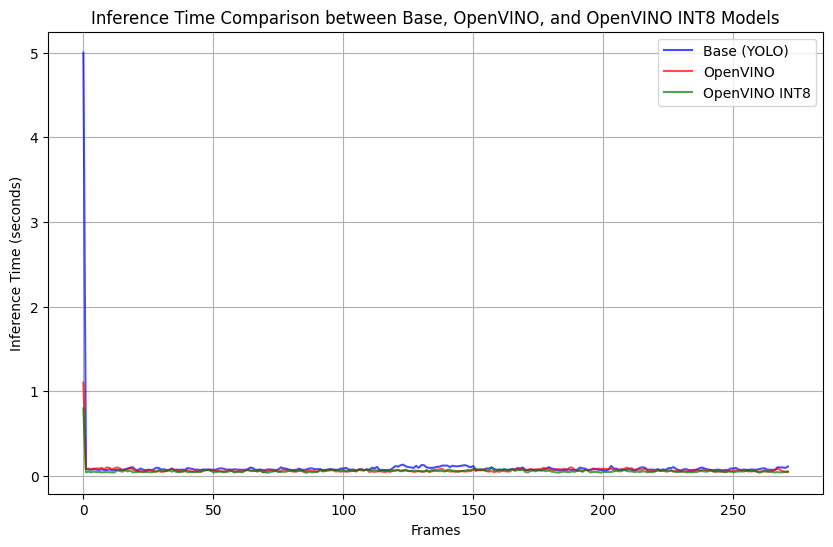

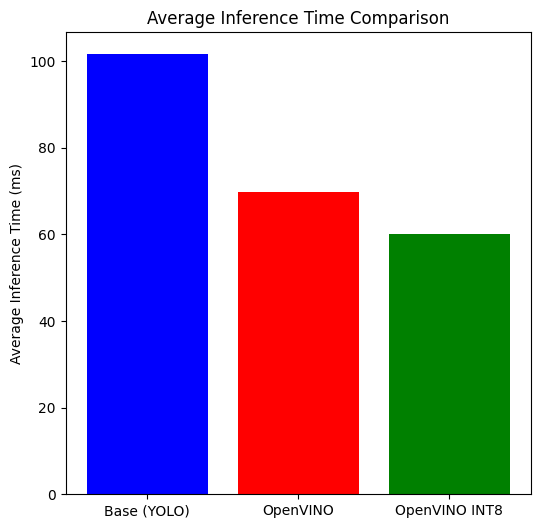

In [17]:
import time
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO  # Make sure you have the correct library

# Function to measure processing time of a video with the base model (YOLO)
def process_video_base(input_video_path):
    model = YOLO('best.pt')  # Base model without optimization
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print("Error opening the video.")
        return []

    times = []  # To store inference times

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Make prediction
        start_time = time.time()
        results = model(frame,imgsz=(216, 416))
        inference_time = time.time() - start_time
        times.append(inference_time)

    cap.release()
    return times

# Function to measure processing time of a video with the OpenVINO model
def process_video_openvino(input_video_path, model_path):
    model = YOLO(model_path)
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print("Error opening the video.")
        return []

    times = []  # To store inference times

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Make prediction
        start_time = time.time()
        results = model(frame, imgsz=(216, 416))  # Adjust image size if necessary
        inference_time = time.time() - start_time
        times.append(inference_time)

    cap.release()
    return times

# Path to the input video (you can use any test video)
input_video_path = '8633314-hd_1920_1080_30fps.mp4'

# Get inference times for the three models
base_times = process_video_base(input_video_path)
openvino_times = process_video_openvino(input_video_path, 'best_openvino_model/')
int8_openvino_times = process_video_openvino(input_video_path, 'best_int8_openvino_model/')

# Calculate average inference time
base_avg_time = sum(base_times) / len(base_times) * 1000  # Convert to milliseconds
openvino_avg_time = sum(openvino_times) / len(openvino_times) * 1000  # Convert to milliseconds
int8_openvino_avg_time = sum(int8_openvino_times) / len(int8_openvino_times) * 1000  # Convert to milliseconds

# Print the results
print(f"Average inference time with the base model: {base_avg_time:.2f} ms")
print(f"Average inference time with the OpenVINO model: {openvino_avg_time:.2f} ms")
print(f"Average inference time with the OpenVINO INT8 model: {int8_openvino_avg_time:.2f} ms")

# Plot inference times
plt.figure(figsize=(10, 6))
plt.plot(base_times, label='Base (YOLO)', color='blue', alpha=0.7)
plt.plot(openvino_times, label='OpenVINO', color='red', alpha=0.7)
plt.plot(int8_openvino_times, label='OpenVINO INT8', color='green', alpha=0.7)
plt.title("Inference Time Comparison between Base, OpenVINO, and OpenVINO INT8 Models")
plt.xlabel("Frames")
plt.ylabel("Inference Time (seconds)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the comparison of average times
plt.figure(figsize=(6, 6))
labels = ['Base (YOLO)', 'OpenVINO', 'OpenVINO INT8']
times = [base_avg_time, openvino_avg_time, int8_openvino_avg_time]
plt.bar(labels, times, color=['blue', 'red', 'green'])
plt.title("Average Inference Time Comparison")
plt.ylabel("Average Inference Time (ms)")
plt.show()


# Real-time Object Detection on Video with YOLO: Inference and Annotation

In [19]:
from ultralytics import YOLO
import cv2

# Load the trained model
model = YOLO('best.pt')

# Input and output video paths
input_video_path = "8633314-hd_1920_1080_30fps.mp4"
output_video_path = "video_output.mp4"

# Open the input video
cap = cv2.VideoCapture(input_video_path)

# Verification and diagnostic message
if not cap.isOpened():
    print("Error opening the video. Check the file path:", input_video_path)
else:
    print("Video loaded successfully.")

# Verify dimensions and configure output settings if the video opens correctly
if cap.isOpened():
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print(f"Dimensions: {width}x{height}, FPS: {fps}")

    # Configure the output video with the original dimensions
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Define confidence and overlap thresholds
    conf_threshold = 0.20  # Confidence threshold
    iou_threshold = 0.22  # Overlap threshold for NMS

    # Process each frame without resizing
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Could not read the frame. End of video.")
            break

        # Perform prediction with the defined thresholds
        results = model(frame, conf=conf_threshold, iou=iou_threshold,imgsz=(216, 416))

        # Annotate the frame with detections
        annotated_frame = results[0].plot()  # Annotate the frame with detections

        # Write the annotated frame to the output video
        out.write(annotated_frame)

    cap.release()
    out.release()
    print(f"Video processed and saved to {output_video_path}")


Video loaded successfully.
Dimensions: 1920x1080, FPS: 29

WARNING ⚠️ imgsz=[216, 416] must be multiple of max stride 32, updating to [224, 416]
0: 224x416 2 Goods, 3 Unripes, 61.6ms
Speed: 2.9ms preprocess, 61.6ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 416)

WARNING ⚠️ imgsz=[216, 416] must be multiple of max stride 32, updating to [224, 416]
0: 224x416 2 Goods, 3 Unripes, 63.6ms
Speed: 1.8ms preprocess, 63.6ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 416)

WARNING ⚠️ imgsz=[216, 416] must be multiple of max stride 32, updating to [224, 416]
0: 224x416 2 Goods, 3 Unripes, 51.6ms
Speed: 1.9ms preprocess, 51.6ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 416)

WARNING ⚠️ imgsz=[216, 416] must be multiple of max stride 32, updating to [224, 416]
0: 224x416 2 Goods, 3 Unripes, 57.2ms
Speed: 5.2ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 416)

WARNING ⚠️ imgsz=[216, 416] must be multiple of max s